<a href="https://colab.research.google.com/github/VanesaHM/ProyectoKaggle/blob/main/99%20-%20modelo%20soluci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **UDEA/ai4eng 20252 - Pruebas Saber Pro Colombia**

Crear un modelo para predecir el rendimiento de los estudiantes en las pruebas Saber Pro

# **Descripción general**

Las Pruebas Saber Pro son exámenes estandarizados que se administran en Colombia para evaluar la calidad y el nivel de conocimiento y competencias de los estudiantes de educación superior, es decir, de instituciones de educación superior como universidades y tecnológicos. Estas pruebas son parte de los esfuerzos del Gobierno de Colombia para monitorear y mejorar la calidad de la educación superior en el país.

Estas Pruebas constan cinco componentes genéricos, Inglés, Lectura Crítica, Competencias Ciudadanas, Razonamiento Cuantitativo y Comunicación Escrita.

Tu tarea será crear un modelo de clasificación que para cada estudiante prediga qué desempeño va a tener: bajo, medio-bajo, medio-alto o alto.

# **Descripción**

El conjunto de datos contiene más de 50 columnas que describen de manera distintos aspectos de cada estudiante, incluyendo:

Información socieconómica: Describen características socieconómicas del estudiante como su estrato, educación de sus padres, estrato, entre otras.

Información de instituciones: Describen las instituciones de donde provienen los estudiantes.

Información del estudiante: Describe particularidades del estudiante como su edad, que programa estudian, la modalidad de estudio, etc.

Información estadística: Describe algunos coeficientes que equipos de estudio han desarrollado que podría ayudar a la clasificación.

Así como muchos otros datos que ayudan a clasificar de manera precisa los niveles de desempeño

## **Preprocesamiento avanzado (KNN + OHE + RobustScaler + SMOTE) con LightGBM**



**1. Importar librerías**

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import pickle
import time


**2. Configuración visual**

In [2]:
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="muted")

**3. Cargar los datos**

In [3]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 2.58GB/s]


**4. Descomprimir los datos**

In [5]:
!unzip udea*.zip > /dev/null

In [6]:
train = pd.read_csv("train.csv")
test  = pd.read_csv('test.csv')

# **ANÁLISIS EXPLORATORIO INICIAL**

Se muestran las primeras filas, tipos y valores nulos.

In [7]:
if train is not None:
    display(train.head())
    display(train.info())
    display(train.isna().sum().sort_values(ascending=False).head(20))
else:
    print('No train available to display.')

,ID,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,F_TIENEAUTOMOVIL,E_PRIVADO_LIBERTAD,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_TIENEINTERNET.1,F_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,Si,N,No,Si,Si,Postgrado,medio-alto,0.322,0.208,0.310,0.267
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,No,N,No,Si,No,Técnica o tecnológica incompleta,bajo,0.311,0.215,0.292,0.264
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,No,N,No,No,Si,Secundaria (Bachillerato) completa,bajo,0.297,0.214,0.305,0.264
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Si,No,N,No,Si,Si,Secundaria (Bachillerato) completa,alto,0.485,0.172,0.252,0.190
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Si,Si,N,No,Si,Si,Primaria completa,medio-bajo,0.316,0.232,0.285,0.294


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692500 entries, 0 to 692499
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ID                           692500 non-null  int64  
 1   PERIODO_ACADEMICO            692500 non-null  int64  
 2   E_PRGM_ACADEMICO             692500 non-null  object 
 3   E_PRGM_DEPARTAMENTO          692500 non-null  object 
 4   E_VALORMATRICULAUNIVERSIDAD  686213 non-null  object 
 5   E_HORASSEMANATRABAJA         661643 non-null  object 
 6   F_ESTRATOVIVIENDA            660363 non-null  object 
 7   F_TIENEINTERNET              665871 non-null  object 
 8   F_EDUCACIONPADRE             669322 non-null  object 
 9   F_TIENELAVADORA              652727 non-null  object 
 10  F_TIENEAUTOMOVIL             648877 non-null  object 
 11  E_PRIVADO_LIBERTAD           692500 non-null  object 
 12  E_PAGOMATRICULAPROPIO        686002 non-null  object 
 13 

None

,0
F_TIENEAUTOMOVIL,43623
F_TIENELAVADORA,39773
F_TIENECOMPUTADOR,38103
F_ESTRATOVIVIENDA,32137
E_HORASSEMANATRABAJA,30857
F_TIENEINTERNET.1,26629
F_TIENEINTERNET,26629
F_EDUCACIONMADRE,23664
F_EDUCACIONPADRE,23178
E_PAGOMATRICULAPROPIO,6498


# **PREPROCESAMIENTO**

El preprocesamiento consiste en transformar los datos originales en una versión limpia y adecuada para el modelo, por eso en esta etapa se imputan valores faltantes, utilizando técnicas como KNN o la moda, se manejan outliers, se codifican las variables categóricas mediante One-Hot Encoding, y se escalan las variables numéricas con métodos robustos como RobustScaler. Además, se equilibra la distribución de la variable objetivo utilizando técnicas como SMOTE; todo esto permite garantizar que los datos sean consistentes, completos y compatibles con los algoritmos de Machine Learning.

In [11]:
print("\n" + "="*70)
print("PREPROCESAMIENTO")
print("="*70)

train_processed = train.copy()
inicio_total = time.time()

ID_COL = "ID"
TARGET = "RENDIMIENTO_GLOBAL"
NUM_VARS = ['PERIODO_ACADEMICO', 'INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']
ESTRATO_MAP = {f'Estrato {i}': i for i in range(1, 7)}
REVERSE_ESTRATO = {v: k for k, v in ESTRATO_MAP.items()}
TEST_SIZE = 0.2
RANDOM_STATE = 42
SAMPLE_FRAC = 0.5

print(f"\nFilas originales: {len(train_processed):,}")

# SAMPLING
if len(train_processed) > 200000:
    print(f"Stratified sampling al {SAMPLE_FRAC*100:.0f}%...")
    train_sample, _ = train_test_split(
        train_processed, train_size=SAMPLE_FRAC, random_state=RANDOM_STATE,
        stratify=train_processed[TARGET]
    )
    train_processed = train_sample.reset_index(drop=True)
    print(f"Filas después: {len(train_processed):,}")

# LIMPIEZA
cols_drop = [c for c in train_processed.columns if ".1" in c]
train_processed.drop(columns=cols_drop, inplace=True, errors='ignore')
cat_vars = [c for c in train_processed.columns if c not in NUM_VARS + [ID_COL, TARGET]]

print(f"Numéricas: {len(NUM_VARS)} | Categóricas: {len(cat_vars)}")

# IMPUTACIÓN F_ESTRATOVIVIENDA
if "F_ESTRATOVIVIENDA" in train_processed.columns:
    socio_vars = [
        'F_TIENEAUTOMOVIL', 'F_TIENECOMPUTADOR', 'F_TIENELAVADORA',
        'F_TIENEINTERNET', 'F_EDUCACIONPADRE', 'F_EDUCACIONMADRE',
        'E_VALORMATRICULAUNIVERSIDAD'
    ]
    socio_vars = [v for v in socio_vars if v in train_processed.columns]

    temp = train_processed[socio_vars + ["F_ESTRATOVIVIENDA"]].copy()
    for col in socio_vars:
        temp[col] = temp[col].astype("category").cat.codes.replace({-1: np.nan})

    temp["F_ESTRATOVIVIENDA"] = temp["F_ESTRATOVIVIENDA"].map(ESTRATO_MAP)

    imputer = KNNImputer(n_neighbors=3, weights="distance")
    imputado = np.round(imputer.fit_transform(temp)[:, -1]).clip(1, 6)
    train_processed["F_ESTRATOVIVIENDA"] = pd.Series(imputado, index=train_processed.index).map(REVERSE_ESTRATO)
    del temp, imputer, imputado

# IMPUTACIÓN CATEGÓRICAS
for col in cat_vars:
    if train_processed[col].isnull().sum() > 0:
        fill_value = train_processed[col].mode()[0] if train_processed[col].nunique() <= 3 else "Desconocido"
        train_processed[col] = train_processed[col].fillna(fill_value)

print("Imputación completada")

# OUTLIERS
for col in NUM_VARS:
    p1, p99 = train_processed[col].quantile([0.01, 0.99])
    train_processed[col] = train_processed[col].clip(p1, p99)

print("Outliers cappeados")

# TRAIN/TEST SPLIT
X = train_processed[NUM_VARS + cat_vars]
y = train_processed[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

del train_processed, X, y
print(f"Train/Test split: {len(X_train):,} / {len(X_test):,}")

# TRANSFORMACIONES
preprocessor = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), NUM_VARS),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True, max_categories=50), cat_vars)
    ],
    remainder="drop"
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

cat_ohe_cols = preprocessor.named_transformers_["cat"].get_feature_names_out(cat_vars)
final_cols = NUM_VARS + list(cat_ohe_cols)

print(f"Features finales: {len(final_cols)}")

# CODIFICAR TARGET
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print(f"Classes: {dict(zip(le.classes_, range(len(le.classes_))))}")

# BALANCEAR
class_counts = np.bincount(y_train_encoded)
imbalance_ratio = class_counts.max() / class_counts.min()

if imbalance_ratio > 2.5:
    print(f"Aplicando SMOTE (ratio: {imbalance_ratio:.2f})...")
    smote = SMOTE(random_state=RANDOM_STATE, n_jobs=-1, k_neighbors=3, sampling_strategy='not majority')
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train_encoded)
else:
    print(f"Balanceo aceptable (ratio: {imbalance_ratio:.2f})")
    X_train_balanced, y_train_balanced = X_train_processed, y_train_encoded

print("\nPREPROCESAMIENTO COMPLETADO\n")


PREPROCESAMIENTO

Filas originales: 692,500
Stratified sampling al 50%...
Filas después: 346,250
Numéricas: 5 | Categóricas: 13
Imputación completada
Outliers cappeados
Train/Test split: 277,000 / 69,250
Features finales: 145
Classes: {'alto': 0, 'bajo': 1, 'medio-alto': 2, 'medio-bajo': 3}
Balanceo aceptable (ratio: 1.02)

PREPROCESAMIENTO COMPLETADO



# **ENTRENAMIENTO**

El entrenamiento es la fase en la que el modelo, como LightGBM, aprende patrones a partir de los datos ya preprocesados; para ello, el dataset se divide en conjuntos de entrenamiento y prueba, se ajustan o fijan hiperparámetros, y se alimenta al modelo con ejemplos que le permitan aprender la relación entre las variables y el objetivo; finalmente, se evalúa su desempeño para medir precisión, capacidad de generalización y posibles errores. El propósito principal es que el modelo adquiera la habilidad de realizar predicciones correctas y estables.


MODELO: LightGBM Classifier

Entrenando LightGBM...
Entrenamiento completado

Validación cruzada (3-fold)...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


CV F1-Weighted: 0.4130 (+/- 0.0003)

Prediciendo en TEST...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



RESULTADOS LightGBM:
  Accuracy:  0.4249
  F1-Score:  0.4125

REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

        alto     0.5325    0.6218    0.5737     17562
        bajo     0.4501    0.5574    0.4980     17299
  medio-alto     0.3170    0.2494    0.2792     17162
  medio-bajo     0.3317    0.2660    0.2952     17227

    accuracy                         0.4249     69250
   macro avg     0.4078    0.4237    0.4115     69250
weighted avg     0.4086    0.4249    0.4125     69250



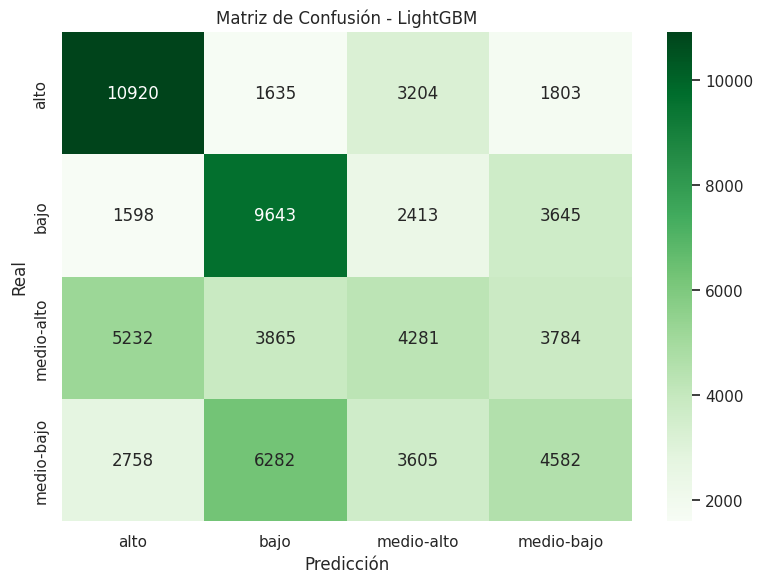


TOP 15 FEATURES MÁS IMPORTANTES:
                                                             Feature  Importance
                                                         INDICADOR_1        1986
                                                         INDICADOR_2        1842
                                                         INDICADOR_3        1704
                                                         INDICADOR_4        1637
                                                   PERIODO_ACADEMICO         827
  E_VALORMATRICULAUNIVERSIDAD_Entre 1 millón y menos de 2.5 millones         459
                        E_VALORMATRICULAUNIVERSIDAD_Menos de 500 mil         455
                                          E_PRGM_DEPARTAMENTO_BOGOTÁ         438
       E_VALORMATRICULAUNIVERSIDAD_Entre 500 mil y menos de 1 millón         393
                                E_HORASSEMANATRABAJA_Más de 30 horas         353
                                            E_PAGOMATRICULAPROPIO_No       

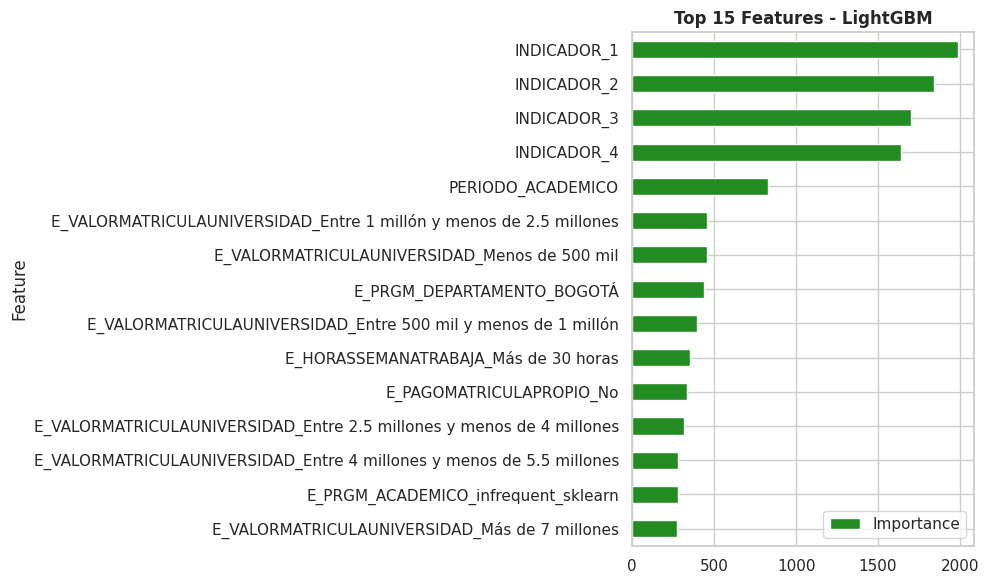


Guardando modelo...
ENTRENAMIENTO COMPLETADO



In [13]:
print("\nMODELO: LightGBM Classifier")

# ENTRENAR
print("\nEntrenando LightGBM...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=-1
)

lgb_model.fit(X_train_balanced, y_train_balanced)
print("Entrenamiento completado")

# VALIDACIÓN CRUZADA
print("\nValidación cruzada (3-fold)...")
cv_scores = cross_val_score(lgb_model, X_train_balanced, y_train_balanced, cv=3, scoring='f1_weighted')
print(f"CV F1-Weighted: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# PREDICCIONES
print("\nPrediciendo en TEST...")
y_pred_lgb = lgb_model.predict(X_test_processed)
y_pred_proba_lgb = lgb_model.predict_proba(X_test_processed)

# MÉTRICAS
acc_lgb = accuracy_score(y_test_encoded, y_pred_lgb)
f1_lgb = f1_score(y_test_encoded, y_pred_lgb, average='weighted')

print(f"\nRESULTADOS LightGBM:")
print(f"  Accuracy:  {acc_lgb:.4f}")
print(f"  F1-Score:  {f1_lgb:.4f}")

print("\nREPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test_encoded, y_pred_lgb, target_names=le.classes_, digits=4))

# MATRIZ DE CONFUSIÓN
cm = confusion_matrix(y_test_encoded, y_pred_lgb)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax,
            xticklabels=le.classes_, yticklabels=le.classes_)
ax.set_title('Matriz de Confusión - LightGBM')
ax.set_ylabel('Real')
ax.set_xlabel('Predicción')
plt.tight_layout()
plt.show()

# IMPORTANCIA DE FEATURES
feature_importance = pd.DataFrame({
    'Feature': final_cols,
    'Importance': lgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTOP 15 FEATURES MÁS IMPORTANTES:")
print(feature_importance.head(15).to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 6))
feature_importance.head(15).sort_values('Importance').plot(
    kind='barh', x='Feature', y='Importance', ax=ax, color='forestgreen'
)
ax.set_title('Top 15 Features - LightGBM', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# GUARDAR MODELO
print("\nGuardando modelo...")
with open("lightgbm_model.pkl", "wb") as f:
    pickle.dump(lgb_model, f)
with open("preprocessor_lgb.pkl", "wb") as f:
    pickle.dump(preprocessor, f)
with open("label_encoder_lgb.pkl", "wb") as f:
    pickle.dump(le, f)

print("ENTRENAMIENTO COMPLETADO\n")

# **PREDICCIÓN EN DATASET COMPLETO**

La predicción en el dataset completo consiste en aplicar el mismo pipeline de preprocesamiento y el modelo previamente entrenado a todos los datos disponibles, con el fin de generar las predicciones finales. En esta etapa se asegura que cada registro pase exactamente por las mismas transformaciones usadas durante el entrenamiento, garantizando coherencia y evitando fugas de información y una vez procesados, el modelo calcula la clase o probabilidad correspondiente para cada caso, y los resultados se guardan para análisis posterior.

In [14]:
print("\nCargando dataset original sin samplear...")
test_proc = test.copy()

print(f"Test original shape: {test_proc.shape}")

# PREPROCESAR TEST
cols_drop = [c for c in test_proc.columns if ".1" in c]
test_proc.drop(columns=cols_drop, inplace=True, errors='ignore')

if "F_ESTRATOVIVIENDA" in test_proc.columns:
    socio_vars = [v for v in socio_vars if v in test_proc.columns]
    temp = test_proc[socio_vars + ["F_ESTRATOVIVIENDA"]].copy()
    for col in socio_vars:
        temp[col] = temp[col].astype("category").cat.codes.replace({-1: np.nan})
    temp["F_ESTRATOVIVIENDA"] = temp["F_ESTRATOVIVIENDA"].map(ESTRATO_MAP)

    imputer = KNNImputer(n_neighbors=3, weights="distance")
    imputado = np.round(imputer.fit_transform(temp)[:, -1]).clip(1, 6)
    test_proc["F_ESTRATOVIVIENDA"] = pd.Series(imputado, index=test_proc.index).map(REVERSE_ESTRATO)
    del temp, imputer, imputado

for col in cat_vars:
    if test_proc[col].isnull().sum() > 0:
        fill_value = test_proc[col].mode()[0] if test_proc[col].nunique() <= 3 else "Desconocido"
        test_proc[col] = test_proc[col].fillna(fill_value)

for col in NUM_VARS:
    p1, p99 = test_proc[col].quantile([0.01, 0.99])
    test_proc[col] = test_proc[col].clip(p1, p99)

print("Test preprocesado")

# TRANSFORMAR
X_test_full = test_proc[NUM_VARS + cat_vars]
X_test_full_processed = preprocessor.transform(X_test_full)

print(f"Transformaciones aplicadas: {X_test_full_processed.shape}")

# PREDECIR
print(f"\nHaciendo predicciones en {len(X_test_full):,} muestras...")
y_pred_encoded = lgb_model.predict(X_test_full_processed)
y_pred = le.inverse_transform(y_pred_encoded)

print("Predicciones completadas")


Cargando dataset original sin samplear...
Test original shape: (296786, 20)
Test preprocesado
Transformaciones aplicadas: (296786, 145)

Haciendo predicciones en 296,786 muestras...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Predicciones completadas


# **CREAR SUBMISSION**

In [15]:
submission = pd.DataFrame({
    'ID': test_proc[ID_COL].values,
    'RENDIMIENTO_GLOBAL': y_pred
})

print(f"\nDistribución de predicciones:")
for cls in le.classes_:
    count = (y_pred == cls).sum()
    pct = count / len(y_pred) * 100
    print(f"  {cls}: {count:,} ({pct:.1f}%)")

# GUARDAR
print("\nGuardando submission.csv...")
submission.to_csv('submission_lightgbm.csv', index=False)
print(f"Archivo: submission_lightgbm.csv")
print(f"Filas: {len(submission):,}")
print(f"Columnas: {list(submission.columns)}")

print("\n" + submission.head(10).to_string(index=False))

tiempo_total = time.time() - inicio_total
print(f"\nTiempo total: {tiempo_total/60:.2f} minutos")
print("="*70)



Distribución de predicciones:
  alto: 88,142 (29.7%)
  bajo: 91,659 (30.9%)
  medio-alto: 58,370 (19.7%)
  medio-bajo: 58,615 (19.7%)

Guardando submission.csv...
Archivo: submission_lightgbm.csv
Filas: 296,786
Columnas: ['ID', 'RENDIMIENTO_GLOBAL']

    ID RENDIMIENTO_GLOBAL
550236               bajo
 98545         medio-alto
499179               alto
782980               bajo
785185               bajo
 58495               bajo
705444               alto
557548               alto
519909               bajo
832058               alto

Tiempo total: 52.44 minutos


In [9]:
!kaggle competitions submit -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia -f submission_lightgbm.csv -m "LightGBM"

100% 4.03M/4.03M [00:00<00:00, 10.1MB/s]
Successfully submitted to UDEA/ai4eng 20252 - Pruebas Saber Pro Colombia